In [1]:
import os
os.chdir("../..")

import torch
import clip
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from torchvision import transforms

import tensorflow as tf

from xplique.wrappers import TorchWrapper
from xplique.plots import plot_attributions
from xplique.attributions import (Saliency, GradientInput, IntegratedGradients, SmoothGrad, VarGrad,
                                  SquareGrad, Occlusion, Rise, GuidedBackprop, Lime, KernelShap, SobolAttributionMethod, HsicAttributionMethod)

2024-06-03 02:15:39.278582: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-03 02:15:39.324199: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-03 02:15:40.010670: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.config.run_functions_eagerly(True)

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_virtual_device_configuration(
    gpus[0],
    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8000)]
)

In [3]:
data_transform =  transforms.Compose([
        transforms.Resize((224,224), interpolation=transforms.InterpolationMode.BICUBIC),
        # transforms.CenterCrop(n_px),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.48145466, 0.4578275, 0.40821073), 
            (0.26862954, 0.26130258, 0.27577711)),
    ])

In [4]:
def load_and_transform_vision_data(image_paths, device, channel_first=False):
    if image_paths is None:
        return None

    image_outputs = []
    
    for image_path in image_paths:
        # with open(image_path, "rb") as fopen:
        #     image = Image.open(fopen).convert("RGB")
        image = cv2.imread(image_path)
        image = Image.fromarray(image)

        image = data_transform(image).to(device)
        image_outputs.append(image)
    image_outputs = torch.stack(image_outputs, dim=0)
    if channel_first:
        return image_outputs
    else:
        image_outputs = image_outputs.permute(0,2,3,1)
        return image_outputs.cpu().numpy()
    

In [5]:
class CLIPModel_Super(torch.nn.Module):
    def __init__(self, 
                 type="ViT-L/14", 
                 download_root=None,
                 device = "cuda"):
        super().__init__()
        self.device = device
        self.model, _ = clip.load(type, device=self.device, download_root=download_root)
        
    def equip_semantic_modal(self, modal_list):
        text = clip.tokenize(modal_list).to(self.device)
        
        with torch.no_grad():
            self.text_features = self.model.encode_text(text)
            self.text_features /= self.text_features.norm(dim=-1, keepdim=True)
            
    def forward(self, vision_inputs):
        
        with torch.no_grad():
            image_features = self.model.encode_image(vision_inputs)
            image_features /= image_features.norm(dim=-1, keepdim=True)
        
        scores = (100.0 * image_features @ self.text_features.T).softmax(dim=-1)
        return scores.float()

In [6]:
text_list=["A dog.", "A car.", "A bird.", "An airplane.", "A bicycle.", "A boat.", "A cat.", "A chair", "A cow.", "A diningtable.", "A horse.", "A motorbike.", "A person.", "A pottedplant.", "A sheep.", "A sofa.", "A train.", "A tvmonitor."]
image_paths=[".assets/dog_image.jpg", ".assets/car_image.jpg", ".assets/bird_image.jpg"]

In [7]:
vis_model = CLIPModel_Super("ViT-L/14", download_root=".checkpoints/CLIP")
print("ok")

ok


In [8]:
vis_model.equip_semantic_modal(text_list)

In [9]:
image_input = load_and_transform_vision_data(image_paths, "cuda")

In [10]:
image_input.shape

(3, 224, 224, 3)

In [11]:
predict_score = vis_model(load_and_transform_vision_data(image_paths, "cuda", True))

In [13]:
X = [cv2.resize(cv2.imread(image_path), (224,224))[..., ::-1] for image_path in image_paths]
# one-hot
Y = np.eye(predict_score.shape[-1])[predict_score.argmax(-1).cpu().numpy()]

In [14]:
predict_score.argmax(-1).cpu().numpy()

array([0, 1, 2])

In [15]:
wrapped_model = TorchWrapper(vis_model.eval(), "cuda")

2024-06-03 02:16:12.693715: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8000 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:17:00.0, compute capability: 8.6
2024-06-03 02:16:12.694164: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 5040 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:b3:00.0, compute capability: 8.6
/home/cry/anaconda3/envs/hsic/lib/python3.8/site-packages/xplique/wrappers/pytorch.py:61: UserWarning: TF is set to run eagerly to avoid conflict with PyTorch. Thus,                       TF functions might be slower
  warnings.warn("TF is set to run eagerly to avoid conflict with PyTorch. Thus,\


2024-06-03 02:16:17.032513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [3,18]
	 [[{{node Placeholder/_1}}]]
/home/cry/anaconda3/envs/hsic/lib/python3.8/site-packages/xplique/wrappers/pytorch.py:141: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  torch_inputs = self.torch.Tensor(np_inputs)
2024-06-03 02:16:17.104956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INF

Method: Occlusion


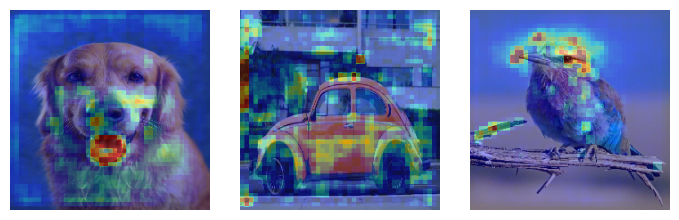

2024-06-03 02:16:45.625592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype bool and shape [4000,7,7,1]
	 [[{{node Placeholder/_0}}]]
2024-06-03 02:17:07.761102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype bool and shape [4000,7,7,1]
	 [[{{node Placeholder/_0}}]]
2024-06-03 02:17:29.308937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype bool and shape

Method: Rise


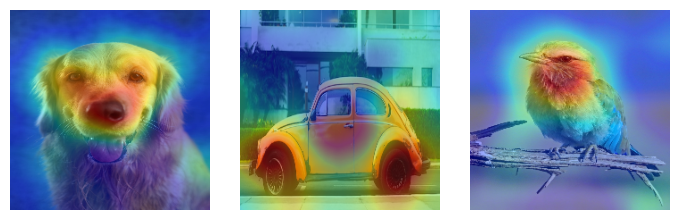

2024-06-03 02:17:50.120202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [2112,8,8,1]
	 [[{{node Placeholder/_0}}]]
2024-06-03 02:18:00.739758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [2112,8,8,1]
	 [[{{node Placeholder/_0}}]]
2024-06-03 02:18:11.305420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and sh

Method: SobolAttributionMethod


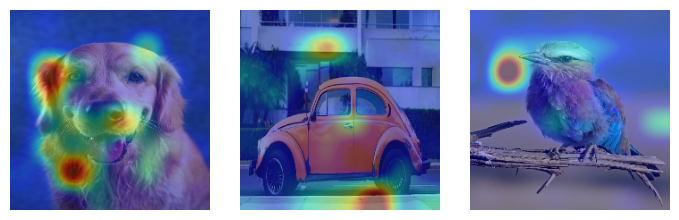

2024-06-03 02:18:22.075019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [500,8,8,1]
	 [[{{node Placeholder/_0}}]]
2024-06-03 02:18:24.592007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1,1,500]
	 [[{{node Placeholder/_1}}]]
2024-06-03 02:18:24.617028: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-06-03 02:18:24.631295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor sta

Method: HsicAttributionMethod


2024-06-03 02:18:29.680877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [64,1,1,500]
	 [[{{node Placeholder/_1}}]]


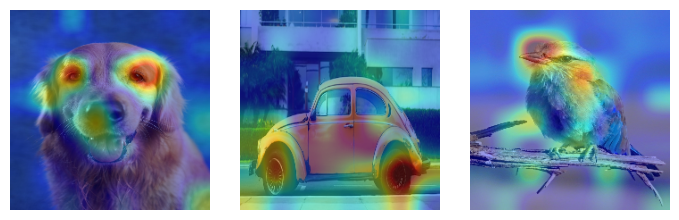

2024-06-03 02:18:29.888362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [3,18]
	 [[{{node Placeholder/_1}}]]
2024-06-03 02:18:30.147537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [4000,778]
	 [[{{node Placeholder/_0}}]]
2024-06-03 02:18:52.692553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [400

Method: Lime


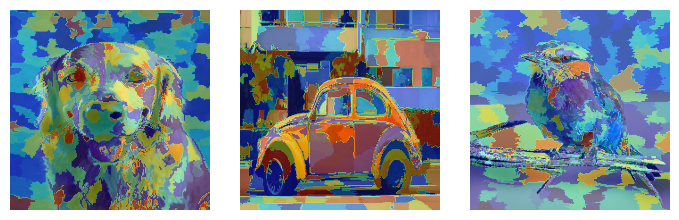

2024-06-03 02:19:51.996354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [3,18]
	 [[{{node Placeholder/_1}}]]
2024-06-03 02:19:52.332255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [4000,778]
	 [[{{node Placeholder/_0}}]]
2024-06-03 02:20:14.375111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32 and shape [400

Method: KernelShap


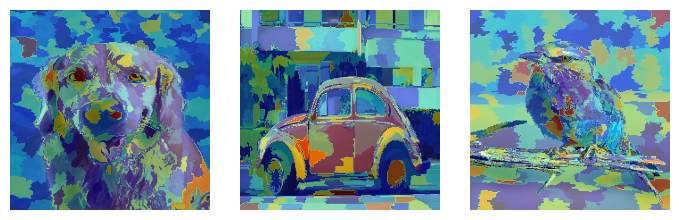

In [16]:
# set batch size parameter
batch_size = 16

# build the explainers
explainers = [
  # Saliency(wrapped_model),
  # GradientInput(wrapped_model),
  # IntegratedGradients(wrapped_model, steps=80, batch_size=batch_size),
  # SmoothGrad(wrapped_model, nb_samples=80, batch_size=batch_size),
  # SquareGrad(wrapped_model, nb_samples=80, batch_size=batch_size),
  # VarGrad(wrapped_model, nb_samples=80, batch_size=batch_size),
  Occlusion(wrapped_model, patch_size=10, patch_stride=5, batch_size=batch_size),
  Rise(wrapped_model, nb_samples=4000, batch_size=batch_size),
  SobolAttributionMethod(wrapped_model, batch_size=batch_size),
  HsicAttributionMethod(wrapped_model, batch_size=batch_size),
  Lime(wrapped_model, nb_samples = 4000, batch_size=batch_size),
  KernelShap(wrapped_model, nb_samples = 4000, batch_size=batch_size)
]

for explainer in explainers:

  explanations = explainer(image_input, Y)

  print(f"Method: {explainer.__class__.__name__}")
  plot_attributions(explanations, X, img_size=2., cmap='jet', alpha=0.4,
                    cols=len(X), absolute_value=True, clip_percentile=0.5)
  plt.show()
  print("\n")